<a href="https://colab.research.google.com/github/caplove/DX_team_4_repo/blob/main/Team_4_Augment_CNN_GRU_Incpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **데이터 가져오기**

---



In [1]:
!git clone https://github.com/caplove/DX_team_4_repo.git

Cloning into 'DX_team_4_repo'...
remote: Enumerating objects: 420, done.
remote: Counting objects: 100% (420/420), done.
remote: Compressing objects: 100% (400/400), done.
remote: Total 420 (delta 218), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (420/420), 15.79 MiB | 5.54 MiB/s, done.
Resolving deltas: 100% (218/218), done.


In [2]:
#과제 설명
from IPython.display import Image
#Image('./image/image_01.png',width=800,height=600)

In [3]:
#Image('./image/image_02.jpg',width=800,height=700)

In [4]:
#Image('./image/image_03.jpg',width=800,height=700)

In [5]:
#Image('./image/image_05.jpg',width=800,height=700)

In [6]:
"""입출력"""
import os

"""전처리"""
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

from scipy.interpolate import CubicSpline      # for Data Augmentation
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

"""시각화"""
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')
import seaborn as sns
#sns.set_style("white")
import itertools
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore') 

## 데이터 프레임

In [7]:
# 하위 폴더내에 각각 파일이 있고, 파일(폴더)명에 class 정보가 있을경우 
# 참조 : https://wikidocs.net/39

df=[]
df = pd.DataFrame()


for (path, dir, files) in os.walk("./DX_team_4_repo/Data/"):
                
        for filename in files:
             ext = os.path.splitext(filename)[-1]  # 확장자가 txt 이면...
             if ext == '.txt':
       
                # 해당파일을 DataFrame으로 읽고 class 추가하기
                print(path + '/' + filename)

                data = pd.read_csv(path + '/'+filename,sep='[:, ,]',names=['ID','accx','accy','accz','gyrx','gyry','gyrz','current','NaN'],header=None,index_col=None)
                data = data.drop(['ID','NaN'],axis=1)     # 다수의 sep는 [ A구분자,B구분자 ] 사용
    
                #Class 컬럼추가 (파일명에서  . 앞에 문자열 추출
                class_name = filename.split('.')[0]     
                data.loc[:,'CLASS']=np.array([class_name]*len(data))    

                #모든 Class 데이터 누적 합치기
                df = pd.concat([df,data])

./DX_team_4_repo/Data//coat_2.txt
./DX_team_4_repo/Data//coat_5.txt
./DX_team_4_repo/Data//idle.txt
./DX_team_4_repo/Data//coat_1.txt
./DX_team_4_repo/Data//suit_1.txt
./DX_team_4_repo/Data//suit_4.txt
./DX_team_4_repo/Data//suit_2.txt
./DX_team_4_repo/Data//suit_5.txt
./DX_team_4_repo/Data//suit_3.txt
./DX_team_4_repo/Data//coat_4.txt
./DX_team_4_repo/Data//coat_3.txt
./DX_team_4_repo/Data//shirt_1.txt
./DX_team_4_repo/Data//shirt_5.txt
./DX_team_4_repo/Data//shirt_3.txt
./DX_team_4_repo/Data//shirt_2.txt
./DX_team_4_repo/Data//shirt_4.txt


## x,y 정의

In [8]:
""" 설명 변수 및 반응변수 구분 """
x = df.drop(['CLASS'],axis=1)
y = df['CLASS']

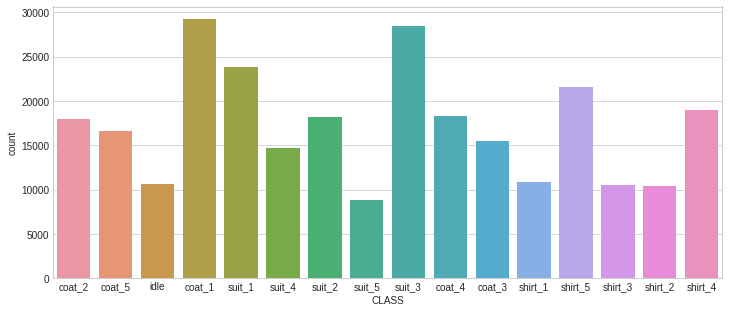

In [9]:
"""분포 확인"""
plt.figure(figsize=(12, 5))
sns.countplot(y)           # 돗수분포
plt.show()

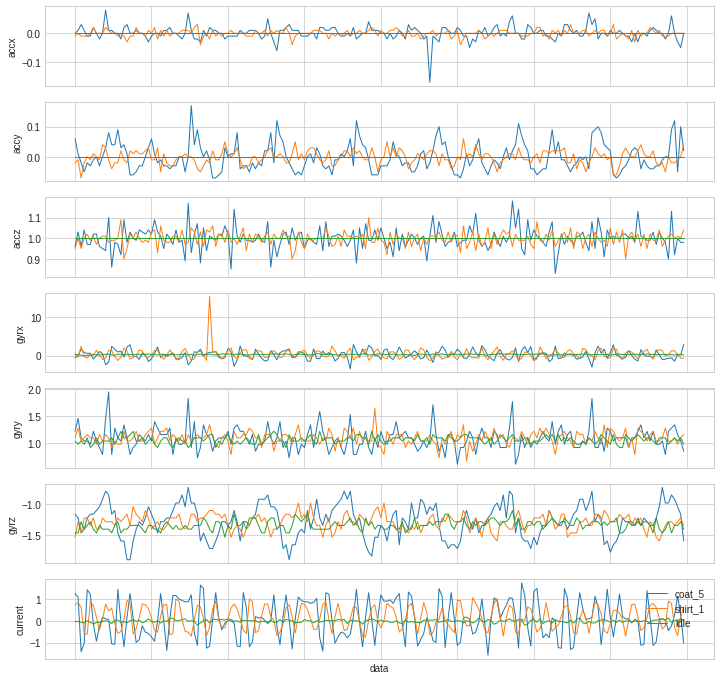

In [10]:
"""데이터 확인"""
# 몇 개의 Class에 대하여, 맨 앞 1초간 데이터 관찰

class_list=['coat_5','shirt_1','idle']
sensor_list=['accx','accy','accz','gyrx','gyry','gyrz','current']
data_length=200       # 2초  @ 10ms sampling

plt.figure(figsize=(12,12))

for i in class_list:
    idx_class = df[df.CLASS == i]

    for j in sensor_list:
        idx_j = sensor_list.index(j)    # j의 위치를 찾아 subplot의 위치를 정함.
        plt.subplot(7,1,idx_j+1)
        plt.plot(idx_class[j][0:data_length],label=i,linewidth=1)
        plt.ylabel(j)
        plt.xticks(visible=False)
    
plt.xlabel('data')
plt.legend(loc='upper right')
plt.show()

In [11]:
#Image('./image/image_06.jpg')

># 데이터 클린징

>>## Kalman Filter

In [12]:
# def kalman_filter(z_meas, x_esti, P):
#     """Kalman Filter Algorithm for One Variable."""
#     # (1) Prediction.
#     x_pred = A * x_esti
#     P_pred = A * P * A + Q

#     # (2) Kalman Gain.
#     K = P_pred * H / (H * P_pred * H + R)

#     # (3) Estimation.
#     x_esti = x_pred + K * (z_meas - H * x_pred)

#     # (4) Error Covariance.
#     P = P_pred - K * H * P_pred

#     return x_esti, P

In [13]:
# # Input parameters.
# time_end = 500
# dt = 1

In [14]:
# # Initialization for system model.
# A = 0.8   # 시간에 따라 상태 변환            Xk+1 = A*Xk + wk   (X: 예측값)
# H = 0.8   # 상태를 측정값으로 변환           Zk   = H*Xk + vx   (Z: 측정값)
# Q = 0.05  # 예측값의 분산
# R = 0.1   # 측정값의 분산
# # Initialization for estimation.
# x_0 = 0   # 14 for book.
# P_0 = 0.1

In [15]:
# time = np.arange(0, time_end, dt)
# n_samples = len(time)
# volt_meas_save = np.zeros(n_samples)
# volt_esti_save = np.zeros(n_samples)

In [16]:
# x_esti, P = None, None
# for i in range(n_samples):
#     z_meas = np.array(x['current'])[i+22000]
#     if i == 0:
#         x_esti, P = x_0, P_0
#     else:
#         x_esti, P = kalman_filter(z_meas, x_esti, P)

#     volt_meas_save[i] = z_meas
#     volt_esti_save[i] = x_esti

In [17]:
# plt.figure(figsize=(20,4))
# plt.plot(time, volt_meas_save, 'r*--', label='Measurements')
# plt.plot(time, volt_esti_save, 'bo-', label='Kalman Filter')
# plt.legend(loc='upper left')
# plt.title('Measurements v.s. Estimation (Kalman Filter)')
# plt.xlabel('Time[ms]')
# plt.ylabel('current[A]')
# #plt.savefig('png/simple_kalman_filter.png')

# **전처리(데이터증강)**

---





>## Scaler
>> 가속센서/전류값 range 유사하여 미적용

In [18]:
"""전처리 / 데이터 증강 """
#Image('./image/image_08.jpg',width=800, height=400)
# jittering, Scaling, Rotation,Permutation,Magnitude Warping,TimeWarp,Cropping ... 

'전처리 / 데이터 증강 '

>## Data Augmentation


>>>### *jittering*

In [19]:
seed_no = 2022
np.random.seed(seed = seed_no)

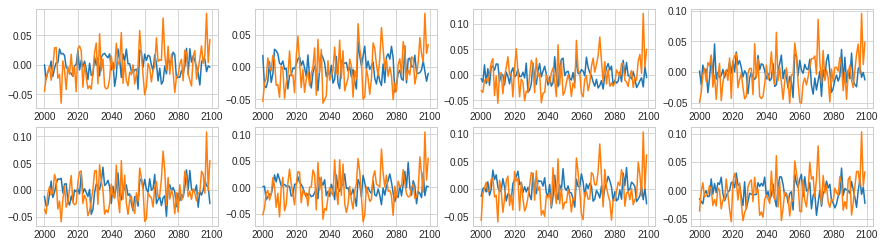

In [20]:
"""jittering"""
sigma = 0.01

def DA_Jitter(X, sigma=sigma):
    myNoise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    return X + myNoise

x_in_jittering = DA_Jitter(x,sigma)

# sample
#x_sample = x.loc[:,'accx':'accz']    # array에서 slicing  
x_sample = x.iloc[2000:2100,0:2]             # pd DataFrame에서 slicing은 .loc(인덱스기반) 또는 .iloc(위치기반) 써야함.
# print(x.shape,x_in.shape)

# x 전체 데이터에 jittering

fig = plt.figure(figsize=(15,4))
for ii in range(8):
    ax = fig.add_subplot(2,4,ii+1)
    ax.plot(DA_Jitter(x_sample,sigma))

>>>### *Magnitude Warping*

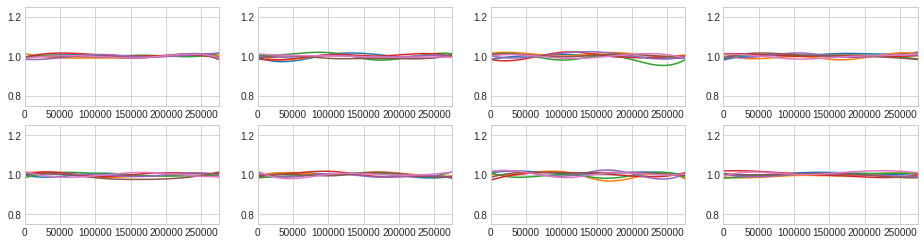

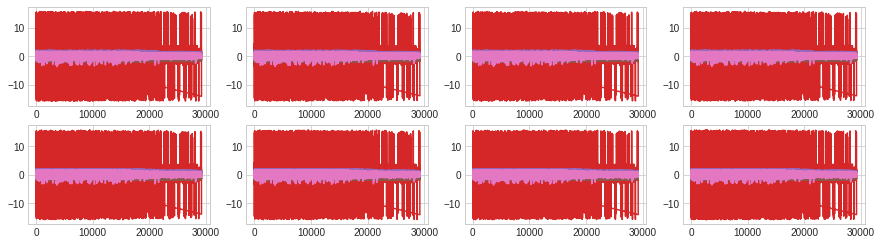

In [21]:
"""Magnitude Warping"""
sigma = 0.01  # default 0.2  (standard deviation)
knot = 4      # default 4    (should be integer)
#seed_no = 2022

## This example using cubic splice is not the best approach to generate random curves. 
## You can use other aprroaches, e.g., Gaussian process regression, Bezier curve, etc.
def GenerateRandomCurves(X, sigma=sigma, knot=4):
    #np.random.seed(seed = seed_no)
    xx = (np.ones((X.shape[1],1))*(np.arange(0,X.shape[0], (X.shape[0]-1)/(knot+1)))).transpose()
    yy = np.random.normal(loc=1.0, scale=sigma, size=(knot+2, X.shape[1]))
    x_range = np.arange(X.shape[0])
    cs_x = CubicSpline(xx[:,0], yy[:,0])
    cs_y = CubicSpline(xx[:,1], yy[:,1])
    cs_z = CubicSpline(xx[:,2], yy[:,2])
    cs_a = CubicSpline(xx[:,3], yy[:,3])  # 추가
    cs_b = CubicSpline(xx[:,4], yy[:,4])  # 추가
    cs_c = CubicSpline(xx[:,5], yy[:,5])  # 추가
    cs_i = CubicSpline(xx[:,6], yy[:,6])  # 추가
    
    return np.array([cs_x(x_range),cs_y(x_range),cs_z(x_range),cs_a(x_range),cs_b(x_range),cs_c(x_range),cs_i(x_range)]).transpose()



## Random curves around 1.0
fig = plt.figure(figsize=(16,4))
for ii in range(8):
    ax = fig.add_subplot(2,4,ii+1)
#    ax.plot(GenerateRandomCurves(x.iloc[:,0:3], sigma))
    ax.plot(GenerateRandomCurves(x, sigma, knot))

    plt.axis([0,x.shape[0],0.75,1.25])

def DA_MagWarp(X, sigma):
    return X * GenerateRandomCurves(X, sigma)

fig = plt.figure(figsize=(15,4))
for ii in range(8):
    ax = fig.add_subplot(2,4,ii+1)
#    ax.plot(DA_MagWarp(x.iloc[:,0:3], sigma))
    ax.plot(DA_MagWarp(x,sigma))

    # ax.set_xlim([0,20000])
    # ax.set_ylim([-5,5])    
    

In [22]:
# x 전체 데이터에 Magnitude Warp
x_in_MagWarp = DA_MagWarp(x,sigma)

>>>### *Scaling*

In [23]:
"""Scaling"""
sigma = 0.01

def DA_Scaling(X, sigma=sigma):
    scalingFactor = np.random.normal(loc=1.0, scale=sigma, size=(1,X.shape[1])) # shape=(1,3)
    myNoise = np.matmul(np.ones((X.shape[0],1)), scalingFactor)
    return X*myNoise

x_in_Scaling = DA_Scaling(x,sigma)    

>>>### *Combination*

In [24]:
"""Combination"""
sigma1 = 0.01
sigma2 = 0.01

x_in_Combination = DA_Jitter(DA_Scaling(x,sigma1),sigma2)    

># Augmented SET 선정

In [25]:
"""Augmentation 결과 적용 list"""
# default
# x_list=[x]

# jittering / MagWarp
# x_list=[x, x_in_jittering, x_in_MagWarp]
# jittering / MagWarp / Scaling
# x_list=[x, x_in_jittering, x_in_MagWarp, x_in_Scaling]

# jittering / MagWarp / Scaling / Combination
x_list=[x, x_in_jittering, x_in_MagWarp, x_in_Scaling, x_in_Combination]
print(x.shape, x_in_jittering.shape, x_in_MagWarp.shape, x_in_Scaling.shape, x_in_Combination.shape, y.shape)

(274582, 7) (274582, 7) (274582, 7) (274582, 7) (274582, 7) (274582,)


In [26]:
print(x.head())
print(y.head())

   accx  accy  accz  gyrx  gyry  gyrz  current
0  0.01 -0.03  1.02 -0.37  0.98 -1.34     0.04
1  0.00 -0.02  0.97  1.22  0.92 -1.40    -0.83
2  0.02 -0.04  1.03  0.43  0.79 -1.40    -0.64
3 -0.01 -0.00  0.97 -0.85  0.92 -1.28     0.04
4 -0.02  0.01  0.98 -1.04  1.16 -1.16     0.10
0    coat_2
1    coat_2
2    coat_2
3    coat_2
4    coat_2
Name: CLASS, dtype: object


In [27]:
# 모듈 불러오기
import os
import time
import copy
import random
# import pickle       # 데이터 저장형태가 pickle일 경우 사용함
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim


# Hyperparameter setting
batch_size = 100
num_classes = 16
num_epochs = 400
window_size = 400  # 시계열일 경우 설정, 만약 레이블이 50마다 있다면? --> 최빈값으로 대표 사용함.

random_seed = 42
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Detect if we have a GPU available

In [28]:
# seed 고정
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

# 전처리(로더)

### 데이터 가공
>> - 데이터를 window size 배수만큼 자르고, train / valid / test 로 나누기

>> - 함수
>>> * split_train_test (x,y,x_list,window_size) : x_list에 있는 증강 데이터를 train / valid / test로 8:1:1 split함. 
>>> * chunk_merge ( splited_x, splited_y, window_size) : train / valid /test로 나눈 데이터를 class별 400개씩 자르고, 이를 merge함.
>>>    - class별로 400개씩 자른 이유는 동일한 label을 갖도록 하기 위해서임. 

In [29]:

# split_train_test

""" 함수정의 """

def split_train_test(x, y, x_list, window_size):

    x_train_all=pd.DataFrame()
    x_valid_all=pd.DataFrame()
    x_test_all=pd.DataFrame()
    y_train_all=pd.DataFrame()
    y_valid_all=pd.DataFrame()
    y_test_all=pd.DataFrame()
    
    class_list=np.array(['idle', 'suit_1','suit_2','suit_3','suit_4','suit_5','shirt_1','shirt_2','shirt_3',
            'shirt_4','shirt_5','coat_1','coat_2','coat_3','coat_4','coat_5'])    

    
    for ii in x_list:
    # Augmented x data
    
        """window_size로 잘라 reshape가능하도록"""
        # 8:1:1 split
        for i in class_list:       # class별로 'idle', 'suit1', ....
            
            idx_class = y==i
            """클래스별 데이터셑 나누기"""
            # train data를 시간순으로 8:2의 비율로 train/validation set으로 분할
            # train, validation, test data의 개수 설정
            n_train = int(0.8 * len(x[idx_class]))
            n_valid = int(0.1 * len(x[idx_class]))
            n_test  = int(0.1 * len(x[idx_class]))
            # print(n_train,n_valid,n_test)
            
            # train/validation set의 개수에 맞게 데이터 분할
            x_train, y_train = x[idx_class][:n_train], y[idx_class][:n_train]
            x_valid, y_valid = x[idx_class][n_train:n_train+n_valid], y[idx_class][n_train:n_train+n_valid]
            x_test,  y_test  = x[idx_class][n_train+n_valid:], y[idx_class][n_train+n_valid:]
            

            # print(f"클래스:{i},학습 : {x_train.shape}{y_train.shape}, 검증 : {x_valid.shape}, 테스트 : {x_test.shape}")

            """class별로 merge"""
            x_train_all = pd.concat([x_train_all,x_train],axis=0)
            y_train_all = pd.concat([y_train_all,y_train])
            x_valid_all = pd.concat([x_valid_all,x_valid],axis=0)
            y_valid_all = pd.concat([y_valid_all,y_valid])
            x_test_all  = pd.concat([x_test_all,x_test],axis=0)
            y_test_all  = pd.concat([y_test_all,y_test])
            
    return x_train_all,y_train_all,x_valid_all,y_valid_all,x_test_all,y_test_all



# list 들어오면, n개씩 쪼개서 return   https://jsikim1.tistory.com/141
def list_chunk(lst,n):
    return [lst[i:i+n] for i in range(0,len(lst),n)], len(lst)//n      #  // 몫


def chunk_merge(x, y, no_of_data):

    class_list=np.array(['idle', 'suit_1','suit_2','suit_3','suit_4','suit_5','shirt_1','shirt_2','shirt_3',
            'shirt_4','shirt_5','coat_1','coat_2','coat_3','coat_4','coat_5'])

    df_x = pd.DataFrame()
    df_y = pd.DataFrame()
    
    xy=pd.concat([x,y],axis=1)
    xy.columns = ['acc_x','acc_y','acc_z','gyr_x','gyr_y','gyr_z','current','class']    
    
    # chunk
    for i in class_list:       # class별로 'idle', 'suit1', ....
        
        df_all, count = list_chunk(xy[xy['class'] ==i],no_of_data)

    df_xy = pd.DataFrame(xy)
    df_x = np.array(df_xy.drop('class',axis=1))
    df_y = np.array(df_xy['class'])


    """class를 숫자로 변환 for pytorch"""
    y_number=[]
    for i in df_y:
        y_tmp=(np.where(i == class_list))[0][0]    # [0][0] 추가해서 데이터만 추출
        #print (i,y_tmp)
        y_number.append(y_tmp)
        #print(i,y_tmp[0][0])

    df_y=np.array(y_number)


    return df_x, df_y

In [30]:
"""데이터 list 정의"""
# x_list = [x]
x_list = [x, x_in_jittering, x_in_MagWarp, x_in_Scaling, x_in_Combination]

In [31]:
"""torch용 data 생성"""
no_of_data=400

# 데이터를 8:1:1로 나누고
x_train_all,y_train_all,x_valid_all,y_valid_all,x_test_all,y_test_all = split_train_test(x, y, x_list, window_size)
# class별로 400개씩 나누어 떨어지도록 나눔.
x_train, y_train = chunk_merge(x_train_all,y_train_all,no_of_data)
x_valid, y_valid = chunk_merge(x_valid_all,y_valid_all,no_of_data)
x_test, y_test   = chunk_merge(x_test_all, y_test_all, no_of_data)

# print(x_test.shape,y_test.shape,x_train.shape,y_train.shape)
print(x_train_all.shape, y_train_all.shape, x_valid_all.shape, y_valid_all.shape, x_test_all.shape, y_test_all.shape)

(1098300, 7) (1098300, 1) (137260, 7) (137260, 1) (137350, 7) (137350, 1)


### 데이터 변환
> - torch용 로더 입력용 변환
>> 2차원 데이터( #####, 7) --> 3차원데이터 (###, 7, 400)로 변환
>>> 7은 센서의 개수, 400은 데이터 싯점,윈도우,4초의 표현임

In [32]:
# train/validation/test 데이터를 window_size 시점 길이로 분할
datasets = []

for set in [(x_train, y_train), (x_valid, y_valid), (x_test, y_test)]:
    # 전체 시간 길이 설정
    T = set[0].shape[0]

    # 전체 X 데이터를 window_size 크기의 time window로 분할
    # split(array, indices_or_sections) 함수는 자투리 없이 딱 나누어 떨어져야 하므로, 400으로 나눠떨어지도록 자투리 처리, split은 딱 떨어져야 함..
    # array 부분을   set[0].iloc[:window_size * (T // window_size),:] 로 slicing 먼저해주어야 함.
    # windows = np.split(set[0].iloc[:window_size * (T // window_size),:], T // window_size, axis=0)  


    x_sliced = set[0][:window_size * (T // window_size),:]
    x_sliced_transposed = x_sliced.T
    windows = np.split(x_sliced_transposed,T // window_size, axis=1)

    # split 하고난, windows는 list형태로 돌아가므로 다시 array 형태로 변환해야 함.
    windows = np.concatenate(windows, axis=0) # 세로로 이어붙임.
    print("windows_original:",windows.shape)
    # print(windows[:7,:])
    # windows = windows.reshape(window_size,7,-1)
    windows = windows.reshape(-1,7,window_size)

    print("windows_reshaped:",windows.shape)
    # print(windows[0,:,:])

    # 전체 y 데이터를 window_size 크기에 맞게 분할
    # labels = np.split(set[1][:, :window_size * (T // window_size)], (T // window_size), -1) # y는 2차원이므로...
    # labels = np.round(np.mean(np.concatenate(labels, 0), -1))  # 싯점마다 voting 해서 label 정의한다. 시간축(-1)기준으로 평균 class를 적용하는데, 여기서는 숫자이므로 나중에 round 처리로 함.

    labels = np.split(set[1][:window_size * (T // window_size)], T // window_size) # y는 2차원이므로...
    labels = np.round(np.mean((np.concatenate(labels, 0).reshape(-1,window_size)), -1))  # 싯점마다 voting 해서 label 정의한다. 시간축(-1)기준으로 평균 class를 적용하는데, 여기서는 숫자이므로 나중에 round 처리로 함.

    labels = labels.astype(np.long)
    # print(labels[0])

    # shape 확인
    print(windows.shape,labels.shape)


    # sample data 확인 (마지막 15번 데이터)
    print("sample data : last label")
    print(windows[-1],labels[-1])

    # 분할된 time window 단위의 X, y 데이터를 tensor 형태로 축적
    datasets.append(torch.utils.data.TensorDataset(torch.Tensor(windows), torch.Tensor(labels)))



# train/validation/test DataLoader 구축
trainset, validset, testset = datasets[0], datasets[1], datasets[2]
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False)
valid_loader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)


windows_original: (19215, 400)
windows_reshaped: (2745, 7, 400)
(2745, 7, 400) (2745,)
sample data : last label
[[ 0.01 -0.   -0.01 ...  0.   -0.01 -0.07]
 [-0.05 -0.04 -0.01 ... -0.04 -0.04 -0.01]
 [ 1.02  0.99  1.   ...  0.99  0.97  1.01]
 ...
 [ 1.04  1.1   1.1  ...  1.04  1.1   1.22]
 [-1.65 -1.16 -1.28 ... -1.34 -1.22 -1.16]
 [-1.09  0.14  0.07 ...  0.1   0.85  0.07]] 15
windows_original: (2401, 400)
windows_reshaped: (343, 7, 400)
(343, 7, 400) (343,)
sample data : last label
[[ 0.01  0.01  0.01 ...  0.    0.01 -0.01]
 [-0.05 -0.04 -0.03 ... -0.06 -0.05 -0.02]
 [ 0.98  1.    1.05 ...  1.01  0.99  1.  ]
 ...
 [ 1.1   1.1   1.22 ...  1.04  1.04  1.16]
 [-1.71 -1.53 -1.4  ... -1.65 -1.53 -1.4 ]
 [ 0.01 -0.77 -0.67 ...  0.78  0.1  -0.8 ]] 15
windows_original: (2401, 400)
windows_reshaped: (343, 7, 400)
(343, 7, 400) (343,)
sample data : last label
[[-0.02  0.04 -0.02 ... -0.   -0.01 -0.04]
 [ 0.04 -0.08  0.05 ...  0.    0.04  0.04]
 [ 1.    0.99  0.96 ...  0.98  0.96  0.93]
 ...
 [ 1

# 1D CNN

## 모형 설계

>> - conv1D (input_size, output_size, kernel_size의미

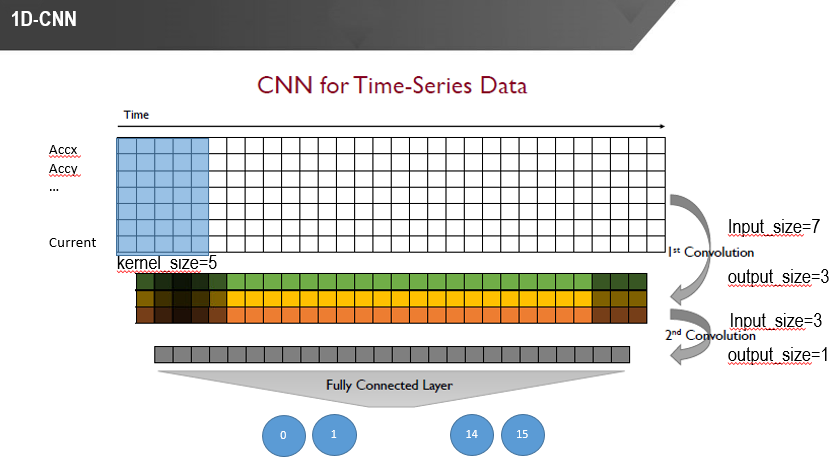

In [ ]:
KERNEL_SIZE_PARAM = 100

# 1-dimensional convolution layer로 구성된 CNN 모델
# 2개의 1-dimensional convolution layer와 1개의 fully-connected layer로 구성되어 있음
class CNN_1D(nn.Module):
    def __init__(self, num_classes):
        super(CNN_1D, self).__init__()
        # 첫 번째 1-dimensional convolution layer 구축
        self.layer1 = nn.Sequential(                # Conv, Relu, Avg를 한번에 레이어로 구성하고, 이를 Sequencial로 사용함.
            # nn.Conv1d(7, 7, kernel_size = KERNEL_SIZE_PARAM),      # Conv(input(입력피쳐개수),output(필터의 개수(종류)), filter_size(필터의 크기 시간축으로 몇개 볼것인지))
            nn.Conv1d(7, 128, kernel_size=KERNEL_SIZE_PARAM),      # Conv(input,output, 3개를 한번에 보겠다.)
            # nn.Conv1d(561, 64, kernel_size=3),      # Conv(input,output, 3개를 한번에 보겠다.)
            nn.ReLU(),
            nn.AvgPool1d(2)                         # 
        )
        # 두 번째 1-dimensional convolution layer 구축
        self.layer2 = nn.Sequential(
            nn.Conv1d(128,32, kernel_size = KERNEL_SIZE_PARAM),
            nn.ReLU(),
            nn.AvgPool1d(2)
        )
        # fully-connected layer 구축
        # self.fc = nn.Linear(64 * 11, num_classes)
        # self.fc = nn.Linear(64 * 1, num_classes)
        self.fc = nn.Linear(800, num_classes)            # 아래 훈련단계에서 에러날경우, nn.Liner(0000, num_classes)  0000 을 에러로그를 보고 바꾼다.(주의)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [ ]:
# 1D CNN 구축
model = CNN_1D(num_classes=num_classes)
model = model.to(device)
print(model)

CNN_1D(
  (layer1): Sequential(
    (0): Conv1d(7, 128, kernel_size=(100,), stride=(1,))
    (1): ReLU()
    (2): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  )
  (layer2): Sequential(
    (0): Conv1d(128, 32, kernel_size=(100,), stride=(1,))
    (1): ReLU()
    (2): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  )
  (fc): Linear(in_features=800, out_features=16, bias=True)
)


In [ ]:
# SGD optimizer 구축하기
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
def train_model(model, dataloaders, criterion, num_epochs, optimizer):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):

      if epoch % 50==0:
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

      # 각 epoch마다 순서대로 training과 validation을 진행
      for phase in ['train', 'val']:
          if phase == 'train':
              model.train()  # 모델을 training mode로 설정
          else:
              model.eval()   # 모델을 validation mode로 설정
              
          running_loss = 0.0
          running_corrects = 0
          running_total = 0

          # training과 validation 단계에 맞는 dataloader에 대하여 학습/검증 진행
          for inputs, labels in dataloaders[phase]:
              inputs = inputs.to(device)
              labels = labels.to(device, dtype=torch.long)
              # labels = labels.to(device, dtype=torch.int64)

              # parameter gradients를 0으로 설정
              optimizer.zero_grad()

              # forward
              # training 단계에서만 gradient 업데이트 수행
              with torch.set_grad_enabled(phase == 'train'):
                  # input을 model에 넣어 output을 도출한 후, loss를 계산함
                  outputs = model(inputs)
                  loss = criterion(outputs, labels)
  
                  # output 중 최댓값의 위치에 해당하는 class로 예측을 수행
                  _, preds = torch.max(outputs, 1)

                  # backward (optimize): training 단계에서만 수행
                  if phase == 'train':
                      loss.backward()
                      optimizer.step()

              # batch별 loss를 축적함
              running_loss += loss.item() * inputs.size(0)
              running_corrects += torch.sum(preds == labels.data)
              running_total += labels.size(0)

          # epoch의 loss 및 accuracy 도출
          epoch_loss = running_loss / running_total
          epoch_acc = running_corrects.double() / running_total

          if epoch % 50==0:
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

          # validation 단계에서 validation loss가 감소할 때마다 best model 가중치를 업데이트함
          if phase == 'val' and epoch_acc > best_acc:
  
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())
          if phase == 'val':
              val_acc_history.append(epoch_acc)

      # print()

    # 전체 학습 시간 계산
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # validation loss가 가장 낮았을 때의 best model 가중치를 불러와 best model을 구축함
    model.load_state_dict(best_model_wts)
    
    # best model 가중치 저장
    # torch.save(best_model_wts, '../output/best_model.pt')
    return model, val_acc_history

In [ ]:
# trining 단계에서 사용할 Dataloader dictionary 생성
dataloaders_dict = {
    'train': train_loader,
    'val': valid_loader
}

In [ ]:
# loss function 설정
criterion = nn.CrossEntropyLoss()

## 학습 / 검증

In [ ]:
# 모델 학습
model, val_acc_history = train_model(model, dataloaders_dict, criterion, num_epochs, optimizer)

Epoch 1/400
----------
train Loss: 2.8122 Acc: 0.0058
val Loss: 2.7439 Acc: 0.1429
Epoch 51/400
----------
train Loss: 1.3640 Acc: 0.5906
val Loss: 2.0788 Acc: 0.2381
Epoch 101/400
----------
train Loss: 0.3202 Acc: 0.9123
val Loss: 1.7613 Acc: 0.4286
Epoch 151/400
----------
train Loss: 0.1058 Acc: 0.9942
val Loss: 1.5906 Acc: 0.6667
Epoch 201/400
----------
train Loss: 0.0172 Acc: 1.0000
val Loss: 1.9154 Acc: 0.6667
Epoch 251/400
----------
train Loss: 0.0096 Acc: 1.0000
val Loss: 2.0505 Acc: 0.6667
Epoch 301/400
----------
train Loss: 0.0066 Acc: 1.0000
val Loss: 2.1372 Acc: 0.6667
Epoch 351/400
----------
train Loss: 0.0050 Acc: 1.0000
val Loss: 2.2013 Acc: 0.6667
Training complete in 9m 22s
Best val Acc: 0.761905


## 테스트

In [ ]:
def test_model(model, test_loader):
    model.eval()   # 모델을 validation mode로 설정
    
    # test_loader에 대하여 검증 진행 (gradient update 방지)
    with torch.no_grad():
        corrects = 0
        total = 0
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device, dtype=torch.long)

            # forward
            # input을 model에 넣어 output을 도출
            outputs = model(inputs)

            # output 중 최댓값의 위치에 해당하는 class로 예측을 수행
            _, preds = torch.max(outputs, 1)

            # batch별 정답 개수를 축적함
            corrects += torch.sum(preds == labels.data)
            total += labels.size(0)

    # accuracy를 도출함
    test_acc = corrects.double() / total
    print('Testing Acc: {:.4f}'.format(test_acc))

In [ ]:
# 모델 검증
test_model(model, test_loader)

Testing Acc: 0.2857


## 별도의 Test Data로 검증

In [ ]:
df=[]
df = pd.DataFrame()


for (path, dir, files) in os.walk("/content/DX_team_4_repo/Data_test"):
                
        for filename in files:
             ext = os.path.splitext(filename)[-1]  # 확장자가 txt 이면...
             if ext == '.txt':
       
                # 해당파일을 DataFrame으로 읽고 class 추가하기
                print(path + '/' + filename)

                data = pd.read_csv(path + '/'+filename,sep='[:, ,]',names=['ID','accx','accy','accz','gyrx','gyry','gyrz','current','NaN'],header=None,index_col=None)
                data = data.drop(['ID','NaN'],axis=1)     # 다수의 sep는 [ A구분자,B구분자 ] 사용
    
                #Class 컬럼추가 (파일명에서  . 앞에 문자열 추출
                class_name = filename.split('.')[0]     
                data.loc[:,'CLASS']=np.array([class_name]*len(data))    

                #모든 Class 데이터 누적 합치기
                df = pd.concat([df,data])

/content/DX_team_4_repo/Data_test/suit_1/suit_1.txt
/content/DX_team_4_repo/Data_test/coat_4/coat_4.txt
/content/DX_team_4_repo/Data_test/shirt_2/shirt_2.txt
/content/DX_team_4_repo/Data_test/coat_2/coat_2.txt
/content/DX_team_4_repo/Data_test/idle/idle.txt
/content/DX_team_4_repo/Data_test/shirt_5/shirt_5.txt
/content/DX_team_4_repo/Data_test/suit_5/suit_5.txt
/content/DX_team_4_repo/Data_test/coat_5/coat_5.txt
/content/DX_team_4_repo/Data_test/shirt_3/shirt_3.txt
/content/DX_team_4_repo/Data_test/shirt_1/shirt_1.txt
/content/DX_team_4_repo/Data_test/suit_3/suit_3.txt
/content/DX_team_4_repo/Data_test/suit_4/suit_4.txt
/content/DX_team_4_repo/Data_test/coat_3/coat_3.txt
/content/DX_team_4_repo/Data_test/suit_2/suit_2.txt
/content/DX_team_4_repo/Data_test/shirt_4/shirt_4.txt
/content/DX_team_4_repo/Data_test/coat_1/coat_1.txt


In [ ]:
""" 설명 변수 및 반응변수 구분 """
x = df.drop(['CLASS'],axis=1)
y = df['CLASS']

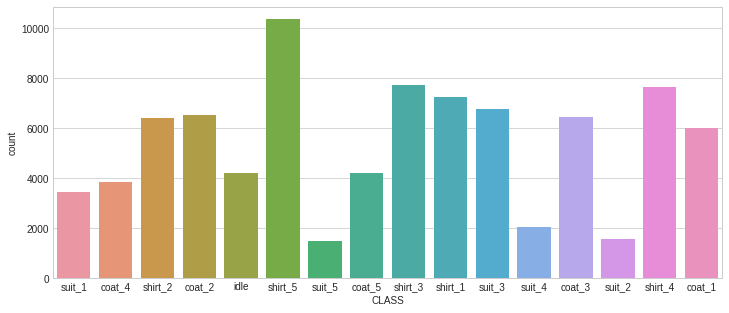

In [ ]:
"""분포 확인"""
plt.figure(figsize=(12, 5))
sns.countplot(y)           # 돗수분포
plt.show()

In [ ]:
x_list = [x]

x_train_all,y_train_all,x_valid_all,y_valid_all,x_test_all,y_test_all = split_train_test(x, y, x_list, window_size)

In [ ]:
"""torch용 data 생성"""
no_of_data=400

x_train, y_train = chunk_merge(x_train_all,y_train_all,no_of_data)
x_valid, y_valid = chunk_merge(x_valid_all,y_valid_all,no_of_data)
x_test, y_test   = chunk_merge(x_test_all, y_test_all, no_of_data)

In [ ]:
# train/validation/test 데이터를 window_size 시점 길이로 분할
datasets = []
for set in [(x_train, y_train), (x_valid, y_valid), (x_test, y_test)]:
    # 전체 시간 길이 설정
    T = set[0].shape[0]

    # 전체 X 데이터를 window_size 크기의 time window로 분할
    # split(array, indices_or_sections) 함수는 자투리 없이 딱 나누어 떨어져야 하므로, 400으로 나눠떨어지도록 자투리 처리, split은 딱 떨어져야 함..
    # array 부분을   set[0].iloc[:window_size * (T // window_size),:] 로 slicing 먼저해주어야 함.
    # windows = np.split(set[0].iloc[:window_size * (T // window_size),:], T // window_size, axis=0)  


    x_sliced = set[0][:window_size * (T // window_size),:]
    x_sliced_transposed = x_sliced.T
    windows = np.split(x_sliced_transposed,T // window_size, axis=1)

    # split 하고난, windows는 list형태로 돌아가므로 다시 array 형태로 변환해야 함.
    windows = np.concatenate(windows, axis=0) # 세로로 이어붙임.
    print("windows_original:",windows.shape)
    # print(windows[:7,:])
    # windows = windows.reshape(window_size,7,-1)
    windows = windows.reshape(-1,7,window_size)

    print("windows_reshaped:",windows.shape)
    # print(windows[0,:,:])

    # 전체 y 데이터를 window_size 크기에 맞게 분할
    # labels = np.split(set[1][:, :window_size * (T // window_size)], (T // window_size), -1) # y는 2차원이므로...
    # labels = np.round(np.mean(np.concatenate(labels, 0), -1))  # 싯점마다 voting 해서 label 정의한다. 시간축(-1)기준으로 평균 class를 적용하는데, 여기서는 숫자이므로 나중에 round 처리로 함.

    labels = np.split(set[1][:window_size * (T // window_size)], T // window_size) # y는 2차원이므로...
    labels = np.round(np.mean((np.concatenate(labels, 0).reshape(-1,window_size)), -1))  # 싯점마다 voting 해서 label 정의한다. 시간축(-1)기준으로 평균 class를 적용하는데, 여기서는 숫자이므로 나중에 round 처리로 함.

    labels = labels.astype(np.long)
    # print(labels[0])

    # shape 확인
    print(windows.shape,labels.shape)


    # sample data 확인 (마지막 15번 데이터)
    print("sample data : last label")
    print(windows[-1],labels[-1])

    # 분할된 time window 단위의 X, y 데이터를 tensor 형태로 축적
    datasets.append(torch.utils.data.TensorDataset(torch.Tensor(windows), torch.Tensor(labels)))


# train/validation/test DataLoader 구축
trainset, validset, testset = datasets[0], datasets[1], datasets[2]
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

windows_original: (1197, 400)
windows_reshaped: (171, 7, 400)
(171, 7, 400) (171,)
sample data : last label
[[ 0.01 -0.01 -0.04 ... -0.03 -0.03 -0.02]
 [ 0.02  0.01 -0.07 ...  0.    0.05  0.03]
 [ 1.01  0.98  1.06 ...  0.92  1.    1.03]
 ...
 [ 1.22  1.16  1.04 ...  0.73  1.1   1.1 ]
 [-0.85 -0.85 -0.98 ... -1.04 -1.04 -1.34]
 [ 0.12  0.15  0.15 ... -0.01  1.31  0.15]] 15
windows_original: (147, 400)
windows_reshaped: (21, 7, 400)
(21, 7, 400) (21,)
sample data : last label
[[-0.    0.01  0.01 ... -0.01 -0.01  0.02]
 [ 0.    0.   -0.04 ...  0.03  0.03 -0.06]
 [ 0.96  1.04  1.1  ...  1.04  0.96  1.11]
 ...
 [ 0.92  0.92  1.1  ...  1.28  1.28  0.98]
 [-1.04 -0.98 -1.1  ... -1.04 -1.1  -1.22]
 [ 0.12  0.05 -0.88 ... -0.75 -0.94 -0.91]] 15
windows_original: (147, 400)
windows_reshaped: (21, 7, 400)
(21, 7, 400) (21,)
sample data : last label
[[-0.   -0.    0.   ... -0.01  0.    0.02]
 [-0.02 -0.02 -0.01 ... -0.04  0.03  0.01]
 [ 0.98  1.05  0.97 ...  1.04  1.    1.  ]
 ...
 [ 1.1   1.22  0

In [ ]:
# 모델 검증 (새로운 싯점 데이터 기준 )
test_model(model, train_loader)

Testing Acc: 0.5906


# GRU /w Attention

In [ ]:
# 모듈 불러오기
import os
import time
import copy
import random
# import pickle       # 데이터 저장형태가 pickle일 경우 사용함
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Hyperparameter setting
batch_size = 32
num_classes = 16
num_epochs = 400
window_size = 400  # 몇 시점의 데이터를 넣을것인가.
input_size = 7     # 7개의 변수  (7차원)
hidden_size = 64    # hidden layer의 차원은 (64차원)
num_layers = 2
bidirectional = True

random_seed = 42
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Detect if we have a GPU available

In [ ]:
# seed 고정
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

## 모형 설계

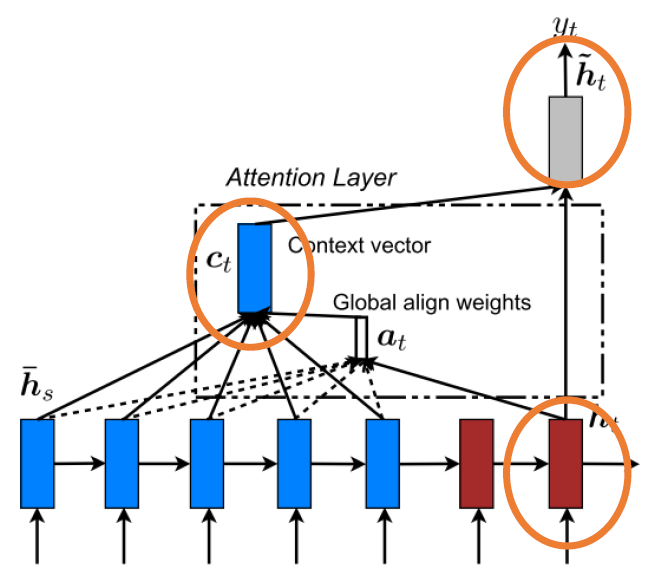

In [ ]:
class Attention(nn.Module):
    def __init__(self, device, hidden_size):
        super(Attention, self).__init__()
        self.device = device
        self.hidden_size = hidden_size

        self.concat_linear = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size, self.hidden_size)

    def forward(self, rnn_outputs, final_hidden_state):        # 입력은 (h1 ~ h*, h* )
        # rnn_output.shape:         (batch_size, seq_len, hidden_size)
        # final_hidden_state.shape: (batch_size, hidden_size)
        # NOTE: hidden_size may also reflect bidirectional hidden states (hidden_size = num_directions * hidden_dim)
        batch_size, seq_len, _ = rnn_outputs.shape  # bidirect에서는 batch 2배
        
        attn_weights = self.attn(rnn_outputs) # (batch_size, seq_len, hidden_dim)
        attn_weights = torch.bmm(attn_weights, final_hidden_state.unsqueeze(2))   # unsqueeze(2)는 두번째 축을 만듬. 2차원 --> 3차원으로 (batch,hidden,1)

        # bmm : 돌려서 행렬곱 시행함.   ---> 결과 alpha1, ~ alpha50까지 나옴.

        
        attn_weights = F.softmax(attn_weights.squeeze(2), dim=1)

        # alpha1*h1 + alpha2*h2 + ... alpha50*h50
        context = torch.bmm(rnn_outputs.transpose(1, 2), attn_weights.unsqueeze(2)).squeeze(2)

        # Wc 가 concat_linear 
        attn_hidden = torch.tanh(self.concat_linear(torch.cat((context, final_hidden_state), dim=1)))

        return attn_hidden, attn_weights

In [ ]:
# GRU_Attention

class GRU_Attention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, bidirectional, device):
        super(GRU_Attention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_directions = 2 if bidirectional == True else 1
        
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        self.attn = Attention(device, hidden_size * self.num_directions)   # 차이점 : Attention함수로 context vector를 도출하고 이결과가 fc로 들어감.
        self.fc = nn.Linear(hidden_size * self.num_directions, num_classes)

    def forward(self, x):
        batch_size, _, seq_len = x.shape
        
        # data dimension: (batch_size x input_size x seq_len) -> (batch_size x seq_len x input_size)로 변환
        x = torch.transpose(x, 1, 2)
        
        # initial hidden states 설정
        h0 = torch.zeros(self.num_layers * self.num_directions, batch_size, self.hidden_size).to(device)
        
        # out: tensor of shape (batch_size, seq_len, hidden_size)
        rnn_output, hiddens = self.rnn(x, h0)    # 출력 둘중의 하나를 가지고 atten을 하게되는데...
        final_state = hiddens.view(self.num_layers, self.num_directions, batch_size, self.hidden_size)[-1]
                      # view는 shape을 변경하는 method임.                                             # -1은 num_layers중에서 마지막것을 가져오려고...    
                      # bydirectional 구조에서 마지막 히든레이어의 정방향, 역방향 중 정방향 h를 가져온것 

        # Handle directions
        final_hidden_state = None
        if self.num_directions == 1:   # 단뱡향
            final_hidden_state = final_state.squeeze(0) # 0번째 축(차원)을 없앰. 
        elif self.num_directions == 2: # 양방향
            h_1, h_2 = final_state[0], final_state[1]
            final_hidden_state = torch.cat((h_1, h_2), 1)  # Concatenate both states    64차원 2개를 이어붙여서 128차원으로 concat 함.

        # final hidden state 기준으로 a 값들과의 상관도를 계산함.
         
        # Push through attention layer
        attn_output, attn_weights = self.attn(rnn_output, final_hidden_state)

        attn_output = self.fc(attn_output)
        return attn_output

In [ ]:
# GRU 모델 구축
gru = GRU_Attention(input_size, hidden_size, num_layers, num_classes, bidirectional, device)
gru = gru.to(device)
print(gru)

GRU_Attention(
  (rnn): GRU(7, 64, num_layers=2, batch_first=True, bidirectional=True)
  (attn): Attention(
    (concat_linear): Linear(in_features=256, out_features=128, bias=True)
    (attn): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc): Linear(in_features=128, out_features=16, bias=True)
)


## 학습

In [ ]:
def train_model(model, dataloaders, criterion, num_epochs, optimizer):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):


        if epoch % 20==0:
          print('Epoch {}/{}'.format(epoch + 1, num_epochs))
          print('-' * 10)
        
        # 각 epoch마다 순서대로 training과 validation을 진행
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 training mode로 설정
            else:
                model.eval()   # 모델을 validation mode로 설정

            running_loss = 0.0
            running_corrects = 0
            running_total = 0

            # training과 validation 단계에 맞는 dataloader에 대하여 학습/검증 진행
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device, dtype=torch.long)

                # parameter gradients를 0으로 설정
                optimizer.zero_grad()

                # forward
                # training 단계에서만 gradient 업데이트 수행
                with torch.set_grad_enabled(phase == 'train'):
                    # input을 model에 넣어 output을 도출한 후, loss를 계산함
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # output 중 최댓값의 위치에 해당하는 class로 예측을 수행
                    _, preds = torch.max(outputs, 1)

                    # backward (optimize): training 단계에서만 수행
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # batch별 loss를 축적함
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                running_total += labels.size(0)

            # epoch의 loss 및 accuracy 도출
            epoch_loss = running_loss / running_total
            epoch_acc = running_corrects.double() / running_total

            if epoch % 20==0:
              print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # validation 단계에서 validation loss가 감소할 때마다 best model 가중치를 업데이트함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        # print()

    # 전체 학습 시간 계산
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # validation loss가 가장 낮았을 때의 best model 가중치를 불러와 best model을 구축함
    model.load_state_dict(best_model_wts)
    
    # best model 가중치 저장
    # torch.save(best_model_wts, '../output/best_model.pt')
    return model, val_acc_history

In [ ]:
# trining 단계에서 사용할 Dataloader dictionary 생성
dataloaders_dict = {
    'train': train_loader,
    'val': valid_loader
}

In [ ]:
# loss function 설정
criterion = nn.CrossEntropyLoss()

In [ ]:
# GRU with attention 모델 학습
gru, gru_val_acc_history = train_model(gru, dataloaders_dict, criterion, num_epochs,
                                       optimizer=optim.Adam(gru.parameters(), lr=0.001))

Epoch 1/400
----------
train Loss: 2.8541 Acc: 0.0000
val Loss: 2.7297 Acc: 0.0952
Epoch 21/400
----------
train Loss: 2.3211 Acc: 0.1637
val Loss: 2.5173 Acc: 0.2381
Epoch 41/400
----------
train Loss: 1.1522 Acc: 0.6550
val Loss: 2.0646 Acc: 0.5238
Epoch 61/400
----------
train Loss: 0.4250 Acc: 0.9064
val Loss: 1.7891 Acc: 0.4762
Epoch 81/400
----------
train Loss: 0.1526 Acc: 0.9942
val Loss: 1.5484 Acc: 0.5238
Epoch 101/400
----------
train Loss: 0.0534 Acc: 1.0000
val Loss: 1.5241 Acc: 0.5714
Epoch 121/400
----------
train Loss: 0.0283 Acc: 1.0000
val Loss: 1.7143 Acc: 0.5714
Epoch 141/400
----------
train Loss: 0.0178 Acc: 1.0000
val Loss: 1.8170 Acc: 0.5714
Epoch 161/400
----------
train Loss: 0.0125 Acc: 1.0000
val Loss: 1.8881 Acc: 0.5714
Epoch 181/400
----------
train Loss: 0.0094 Acc: 1.0000
val Loss: 1.9498 Acc: 0.6190
Epoch 201/400
----------
train Loss: 0.0073 Acc: 1.0000
val Loss: 2.0105 Acc: 0.6190
Epoch 221/400
----------
train Loss: 0.0059 Acc: 1.0000
val Loss: 2.071

## 검증

In [ ]:
def test_model(model, test_loader):
    model.eval()   # 모델을 validation mode로 설정
    
    # test_loader에 대하여 검증 진행 (gradient update 방지)
    with torch.no_grad():
        corrects = 0
        total = 0
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device, dtype=torch.long)

            # forward
            # input을 model에 넣어 output을 도출
            outputs = model(inputs)

            # output 중 최댓값의 위치에 해당하는 class로 예측을 수행
            _, preds = torch.max(outputs, 1)

            # batch별 정답 개수를 축적함
            corrects += torch.sum(preds == labels.data)
            total += labels.size(0)

    # accuracy를 도출함
    test_acc = corrects.double() / total
    print('Testing Acc: {:.4f}'.format(test_acc))

In [ ]:
# GRU with attention 모델 검증하기 (Acc: 0.8889)
# Benchmark model인 GRU(Acc: 0.8000)와 비교했을 때, Attetion의 적용이 성능 향상에 도움이 됨을 알 수 있음
test_model(gru, test_loader)

Testing Acc: 0.5714


## 별도의 Test Data로 검증

In [ ]:
df=[]
df = pd.DataFrame()

for (path, dir, files) in os.walk("/content/DX_team_4_repo/Data_test"):
                
        for filename in files:
             ext = os.path.splitext(filename)[-1]  # 확장자가 txt 이면...
             if ext == '.txt':
       
                # 해당파일을 DataFrame으로 읽고 class 추가하기
                print(path + '/' + filename)

                data = pd.read_csv(path + '/'+filename,sep='[:, ,]',names=['ID','accx','accy','accz','gyrx','gyry','gyrz','current','NaN'],header=None,index_col=None)
                data = data.drop(['ID','NaN'],axis=1)     # 다수의 sep는 [ A구분자,B구분자 ] 사용
    
                #Class 컬럼추가 (파일명에서  . 앞에 문자열 추출
                class_name = filename.split('.')[0]     
                data.loc[:,'CLASS']=np.array([class_name]*len(data))    

                #모든 Class 데이터 누적 합치기
                df = pd.concat([df,data])

/content/DX_team_4_repo/Data_test/suit_1/suit_1.txt
/content/DX_team_4_repo/Data_test/coat_4/coat_4.txt
/content/DX_team_4_repo/Data_test/shirt_2/shirt_2.txt
/content/DX_team_4_repo/Data_test/coat_2/coat_2.txt
/content/DX_team_4_repo/Data_test/idle/idle.txt
/content/DX_team_4_repo/Data_test/shirt_5/shirt_5.txt
/content/DX_team_4_repo/Data_test/suit_5/suit_5.txt
/content/DX_team_4_repo/Data_test/coat_5/coat_5.txt
/content/DX_team_4_repo/Data_test/shirt_3/shirt_3.txt
/content/DX_team_4_repo/Data_test/shirt_1/shirt_1.txt
/content/DX_team_4_repo/Data_test/suit_3/suit_3.txt
/content/DX_team_4_repo/Data_test/suit_4/suit_4.txt
/content/DX_team_4_repo/Data_test/coat_3/coat_3.txt
/content/DX_team_4_repo/Data_test/suit_2/suit_2.txt
/content/DX_team_4_repo/Data_test/shirt_4/shirt_4.txt
/content/DX_team_4_repo/Data_test/coat_1/coat_1.txt


In [ ]:
""" 설명 변수 및 반응변수 구분 """
x = df.drop(['CLASS'],axis=1)
y = df['CLASS']

In [ ]:
x_list = [x]

x_train_all,y_train_all,x_valid_all,y_valid_all,x_test_all,y_test_all = split_train_test(x, y, x_list, window_size)

In [ ]:
"""torch용 data 생성"""
no_of_data=400

x_train, y_train = chunk_merge(x_train_all,y_train_all,no_of_data)
x_valid, y_valid = chunk_merge(x_valid_all,y_valid_all,no_of_data)
x_test, y_test   = chunk_merge(x_test_all, y_test_all, no_of_data)

In [ ]:
# train/validation/test 데이터를 window_size 시점 길이로 분할
datasets = []
for set in [(x_train, y_train), (x_valid, y_valid), (x_test, y_test)]:
    # 전체 시간 길이 설정
    T = set[0].shape[0]

    # 전체 X 데이터를 window_size 크기의 time window로 분할
    # split(array, indices_or_sections) 함수는 자투리 없이 딱 나누어 떨어져야 하므로, 400으로 나눠떨어지도록 자투리 처리, split은 딱 떨어져야 함..
    # array 부분을   set[0].iloc[:window_size * (T // window_size),:] 로 slicing 먼저해주어야 함.
    # windows = np.split(set[0].iloc[:window_size * (T // window_size),:], T // window_size, axis=0)  


    x_sliced = set[0][:window_size * (T // window_size),:]
    x_sliced_transposed = x_sliced.T
    windows = np.split(x_sliced_transposed,T // window_size, axis=1) # axis=1 이면, 가로로 자름.

    # split 하고난, windows는 list형태로 돌아가므로 다시 array 형태로 변환해야 함.
    windows = np.concatenate(windows, axis=0) # axis=0 이면, 세로로 이어붙임.
    print("windows_original:",windows.shape)
    # print(windows[:7,:])
    # windows = windows.reshape(window_size,7,-1)
    windows = windows.reshape(-1,7,window_size)

    print("windows_reshaped:",windows.shape)
    # print(windows[0,:,:])

    # 전체 y 데이터를 window_size 크기에 맞게 분할
    # labels = np.split(set[1][:, :window_size * (T // window_size)], (T // window_size), -1) # y는 2차원이므로...
    # labels = np.round(np.mean(np.concatenate(labels, 0), -1))  # 싯점마다 voting 해서 label 정의한다. 시간축(-1)기준으로 평균 class를 적용하는데, 여기서는 숫자이므로 나중에 round 처리로 함.

    labels = np.split(set[1][:window_size * (T // window_size)], T // window_size) # y는 2차원이므로...
    labels = np.round(np.mean((np.concatenate(labels, 0).reshape(-1,window_size)), -1))  # 싯점마다 voting 해서 label 정의한다. 시간축(-1)기준으로 평균 class를 적용하는데, 여기서는 숫자이므로 나중에 round 처리로 함.

    labels = labels.astype(np.long)
    # print(labels[0])

    # shape 확인
    print(windows.shape,labels.shape)


    # sample data 확인 (마지막 15번 데이터)
    print("sample data : last label")
    print(windows[-1],labels[-1])

    # 분할된 time window 단위의 X, y 데이터를 tensor 형태로 축적
    datasets.append(torch.utils.data.TensorDataset(torch.Tensor(windows), torch.Tensor(labels)))



# train/validation/test DataLoader 구축
trainset, validset, testset = datasets[0], datasets[1], datasets[2]
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

windows_original: (1197, 400)
windows_reshaped: (171, 7, 400)
(171, 7, 400) (171,)
sample data : last label
[[ 0.01 -0.01 -0.04 ... -0.03 -0.03 -0.02]
 [ 0.02  0.01 -0.07 ...  0.    0.05  0.03]
 [ 1.01  0.98  1.06 ...  0.92  1.    1.03]
 ...
 [ 1.22  1.16  1.04 ...  0.73  1.1   1.1 ]
 [-0.85 -0.85 -0.98 ... -1.04 -1.04 -1.34]
 [ 0.12  0.15  0.15 ... -0.01  1.31  0.15]] 15
windows_original: (147, 400)
windows_reshaped: (21, 7, 400)
(21, 7, 400) (21,)
sample data : last label
[[-0.    0.01  0.01 ... -0.01 -0.01  0.02]
 [ 0.    0.   -0.04 ...  0.03  0.03 -0.06]
 [ 0.96  1.04  1.1  ...  1.04  0.96  1.11]
 ...
 [ 0.92  0.92  1.1  ...  1.28  1.28  0.98]
 [-1.04 -0.98 -1.1  ... -1.04 -1.1  -1.22]
 [ 0.12  0.05 -0.88 ... -0.75 -0.94 -0.91]] 15
windows_original: (147, 400)
windows_reshaped: (21, 7, 400)
(21, 7, 400) (21,)
sample data : last label
[[-0.   -0.    0.   ... -0.01  0.    0.02]
 [-0.02 -0.02 -0.01 ... -0.04  0.03  0.01]
 [ 0.98  1.05  0.97 ...  1.04  1.    1.  ]
 ...
 [ 1.1   1.22  0

In [ ]:
# 모델 검증 (새로운 싯점 데이터 기준 )
test_model(gru, test_loader)

Testing Acc: 0.5714


# InceptionTime

> ## 모형 설계

In [33]:
import numpy as np 
import time

import torch 
import torch.nn as nn
import torch.nn.functional as F 

import matplotlib.pyplot as plt
from collections import OrderedDict

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import RobustScaler

In [34]:
# Hyperparameter setting
batch_size = 32
num_classes = 16
num_epochs = 400
window_size = 400  # 몇 시점의 데이터를 넣을것인가.
input_size = 7     # 7개의 변수  (7차원)
hidden_size = 64    # hidden layer의 차원은 (64차원)

random_seed = 42
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Detect if we have a GPU available

# seed 고정
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [35]:
def correct_sizes(sizes):
	corrected_sizes = [s if s % 2 != 0 else s - 1 for s in sizes]
	return corrected_sizes


def pass_through(X):
	return X


class Inception(nn.Module):
	def __init__(self, in_channels, n_filters, kernel_sizes=[9, 19, 39], bottleneck_channels=32, activation=nn.ReLU(), return_indices=False):
		"""
		: param in_channels				Number of input channels (input features)
		: param n_filters				Number of filters per convolution layer => out_channels = 4*n_filters
		: param kernel_sizes			List of kernel sizes for each convolution.
										Each kernel size must be odd number that meets -> "kernel_size % 2 !=0".
										This is nessesery because of padding size.
										For correction of kernel_sizes use function "correct_sizes". 
		: param bottleneck_channels		Number of output channels in bottleneck. 
										Bottleneck wont be used if nuber of in_channels is equal to 1.
		: param activation				Activation function for output tensor (nn.ReLU()). 
		: param return_indices			Indices are needed only if we want to create decoder with InceptionTranspose with MaxUnpool1d. 
		"""
		super(Inception, self).__init__()
		self.return_indices=return_indices
		if in_channels > 1:
			self.bottleneck = nn.Conv1d(
								in_channels=in_channels, 
								out_channels=bottleneck_channels, 
								kernel_size=1, 
								stride=1, 
								bias=False
								)
		else:
			self.bottleneck = pass_through
			bottleneck_channels = 1

		self.conv_from_bottleneck_1 = nn.Conv1d(
										in_channels=bottleneck_channels, 
										out_channels=n_filters, 
										kernel_size=kernel_sizes[0], 
										stride=1, 
										padding=kernel_sizes[0]//2, 
										bias=False
										)
		self.conv_from_bottleneck_2 = nn.Conv1d(
										in_channels=bottleneck_channels, 
										out_channels=n_filters, 
										kernel_size=kernel_sizes[1], 
										stride=1, 
										padding=kernel_sizes[1]//2, 
										bias=False
										)
		self.conv_from_bottleneck_3 = nn.Conv1d(
										in_channels=bottleneck_channels, 
										out_channels=n_filters, 
										kernel_size=kernel_sizes[2], 
										stride=1, 
										padding=kernel_sizes[2]//2, 
										bias=False
										)
		self.max_pool = nn.MaxPool1d(kernel_size=3, stride=1, padding=1, return_indices=return_indices)
		self.conv_from_maxpool = nn.Conv1d(
									in_channels=in_channels, 
									out_channels=n_filters, 
									kernel_size=1, 
									stride=1,
									padding=0, 
									bias=False
									)
		self.batch_norm = nn.BatchNorm1d(num_features=4*n_filters)
		self.activation = activation

	def forward(self, X):
		# step 1
		Z_bottleneck = self.bottleneck(X)
		if self.return_indices:
			Z_maxpool, indices = self.max_pool(X)
		else:
			Z_maxpool = self.max_pool(X)
		# step 2
		Z1 = self.conv_from_bottleneck_1(Z_bottleneck)
		Z2 = self.conv_from_bottleneck_2(Z_bottleneck)
		Z3 = self.conv_from_bottleneck_3(Z_bottleneck)
		Z4 = self.conv_from_maxpool(Z_maxpool)
		# step 3 
		Z = torch.cat([Z1, Z2, Z3, Z4], axis=1)
		Z = self.activation(self.batch_norm(Z))
		if self.return_indices:
			return Z, indices
		else:
			return Z


class InceptionBlock(nn.Module):
	def __init__(self, in_channels, n_filters=32, kernel_sizes=[9,19,39], bottleneck_channels=32, use_residual=True, activation=nn.ReLU(), return_indices=False):
		super(InceptionBlock, self).__init__()
		self.use_residual = use_residual
		self.return_indices = return_indices
		self.activation = activation
		self.inception_1 = Inception(
							in_channels=in_channels,
							n_filters=n_filters,
							kernel_sizes=kernel_sizes,
							bottleneck_channels=bottleneck_channels,
							activation=activation,
							return_indices=return_indices
							)
		self.inception_2 = Inception(
							in_channels=4*n_filters,
							n_filters=n_filters,
							kernel_sizes=kernel_sizes,
							bottleneck_channels=bottleneck_channels,
							activation=activation,
							return_indices=return_indices
							)
		self.inception_3 = Inception(
							in_channels=4*n_filters,
							n_filters=n_filters,
							kernel_sizes=kernel_sizes,
							bottleneck_channels=bottleneck_channels,
							activation=activation,
							return_indices=return_indices
							)	
		if self.use_residual:
			self.residual = nn.Sequential(
								nn.Conv1d(
									in_channels=in_channels, 
									out_channels=4*n_filters, 
									kernel_size=1,
									stride=1,
									padding=0
									),
								nn.BatchNorm1d(
									num_features=4*n_filters
									)
								)

	def forward(self, X):
		if self.return_indices:
			Z, i1 = self.inception_1(X)
			Z, i2 = self.inception_2(Z)
			Z, i3 = self.inception_3(Z)
		else:
			Z = self.inception_1(X)
			Z = self.inception_2(Z)
			Z = self.inception_3(Z)
		if self.use_residual:
			Z = Z + self.residual(X)
			Z = self.activation(Z)
		if self.return_indices:
			return Z,[i1, i2, i3]
		else:
			return Z



class InceptionTranspose(nn.Module):
	def __init__(self, in_channels, out_channels, kernel_sizes=[9, 19, 39], bottleneck_channels=32, activation=nn.ReLU()):
		"""
		: param in_channels				Number of input channels (input features)
		: param n_filters				Number of filters per convolution layer => out_channels = 4*n_filters
		: param kernel_sizes			List of kernel sizes for each convolution.
										Each kernel size must be odd number that meets -> "kernel_size % 2 !=0".
										This is nessesery because of padding size.
										For correction of kernel_sizes use function "correct_sizes". 
		: param bottleneck_channels		Number of output channels in bottleneck. 
										Bottleneck wont be used if nuber of in_channels is equal to 1.
		: param activation				Activation function for output tensor (nn.ReLU()). 
		"""
		super(InceptionTranspose, self).__init__()
		self.activation = activation
		self.conv_to_bottleneck_1 = nn.ConvTranspose1d(
										in_channels=in_channels, 
										out_channels=bottleneck_channels, 
										kernel_size=kernel_sizes[0], 
										stride=1, 
										padding=kernel_sizes[0]//2, 
										bias=False
										)
		self.conv_to_bottleneck_2 = nn.ConvTranspose1d(
										in_channels=in_channels, 
										out_channels=bottleneck_channels, 
										kernel_size=kernel_sizes[1], 
										stride=1, 
										padding=kernel_sizes[1]//2, 
										bias=False
										)
		self.conv_to_bottleneck_3 = nn.ConvTranspose1d(
										in_channels=in_channels, 
										out_channels=bottleneck_channels, 
										kernel_size=kernel_sizes[2], 
										stride=1, 
										padding=kernel_sizes[2]//2, 
										bias=False
										)
		self.conv_to_maxpool = nn.Conv1d(
									in_channels=in_channels, 
									out_channels=out_channels, 
									kernel_size=1, 
									stride=1,
									padding=0, 
									bias=False
									)
		self.max_unpool = nn.MaxUnpool1d(kernel_size=3, stride=1, padding=1)
		self.bottleneck = nn.Conv1d(
								in_channels=3*bottleneck_channels, 
								out_channels=out_channels, 
								kernel_size=1, 
								stride=1, 
								bias=False
								)
		self.batch_norm = nn.BatchNorm1d(num_features=out_channels)

		def forward(self, X, indices):
			Z1 = self.conv_to_bottleneck_1(X)
			Z2 = self.conv_to_bottleneck_2(X)
			Z3 = self.conv_to_bottleneck_3(X)
			Z4 = self.conv_to_maxpool(X)

			Z = torch.cat([Z1, Z2, Z3], axis=1)
			MUP = self.max_unpool(Z4, indices)
			BN = self.bottleneck(Z)
			# another possibility insted of sum BN and MUP is adding 2nd bottleneck transposed convolution
			
			return self.activation(self.batch_norm(BN + MUP))


class InceptionTransposeBlock(nn.Module):
	def __init__(self, in_channels, out_channels=32, kernel_sizes=[9,19,39], bottleneck_channels=32, use_residual=True, activation=nn.ReLU()):
		super(InceptionTransposeBlock, self).__init__()
		self.use_residual = use_residual
		self.activation = activation
		self.inception_1 = InceptionTranspose(
							in_channels=in_channels,
							out_channels=in_channels,
							kernel_sizes=kernel_sizes,
							bottleneck_channels=bottleneck_channels,
							activation=activation
							)
		self.inception_2 = InceptionTranspose(
							in_channels=in_channels,
							out_channels=in_channels,
							kernel_sizes=kernel_sizes,
							bottleneck_channels=bottleneck_channels,
							activation=activation
							)
		self.inception_3 = InceptionTranspose(
							in_channels=in_channels,
							out_channels=out_channels,
							kernel_sizes=kernel_sizes,
							bottleneck_channels=bottleneck_channels,
							activation=activation
							)	
		if self.use_residual:
			self.residual = nn.Sequential(
								nn.ConvTranspose1d(
									in_channels=in_channels, 
									out_channels=out_channels, 
									kernel_size=1,
									stride=1,
									padding=0
									),
								nn.BatchNorm1d(
									num_features=out_channels
									)
								)

	def forward(self, X, indices):
		assert len(indices)==3
		Z = self.inception_1(X, indices[2])
		Z = self.inception_2(Z, indices[1])
		Z = self.inception_3(Z, indices[0])
		if self.use_residual:
			Z = Z + self.residual(X)
			Z = self.activation(Z)
		return Z

class Flatten(nn.Module):
	def __init__(self, out_features):
		super(Flatten, self).__init__()
		self.output_dim = out_features

	def forward(self, x):
		return x.view(-1, self.output_dim)
    
class Reshape(nn.Module):
	def __init__(self, out_shape):
		super(Reshape, self).__init__()
		self.out_shape = out_shape

	def forward(self, x):
		return x.view(-1, *self.out_shape)

In [36]:
InceptionTime = nn.Sequential(
                    Reshape(out_shape=(7, window_size)),
                    InceptionBlock(
                        in_channels=input_size, 
                        n_filters=32, 
                        kernel_sizes=[5, 11, 23],
                        bottleneck_channels=32,
                        use_residual=True,
                        activation=nn.ReLU()
                    ),
                    InceptionBlock(
                        in_channels=32*4, 
                        n_filters=32, 
                        kernel_sizes=[5, 11, 23],
                        bottleneck_channels=32,
                        use_residual=True,
                        activation=nn.ReLU()
                    ),
                    nn.AdaptiveAvgPool1d(output_size=1),
                    Flatten(out_features=32*4*1),
                    nn.Linear(in_features=4*32*1, out_features=num_classes)
        )

In [37]:
InceptionTime = InceptionTime.to(device)
InceptionTime

Sequential(
  (0): Reshape()
  (1): InceptionBlock(
    (activation): ReLU()
    (inception_1): Inception(
      (bottleneck): Conv1d(7, 32, kernel_size=(1,), stride=(1,), bias=False)
      (conv_from_bottleneck_1): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      (conv_from_bottleneck_2): Conv1d(32, 32, kernel_size=(11,), stride=(1,), padding=(5,), bias=False)
      (conv_from_bottleneck_3): Conv1d(32, 32, kernel_size=(23,), stride=(1,), padding=(11,), bias=False)
      (max_pool): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
      (conv_from_maxpool): Conv1d(7, 32, kernel_size=(1,), stride=(1,), bias=False)
      (batch_norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
    )
    (inception_2): Inception(
      (bottleneck): Conv1d(128, 32, kernel_size=(1,), stride=(1,), bias=False)
      (conv_from_bottleneck_1): Conv1d(32, 32, kernel_size=(5,), stride=(1,), pad

In [38]:
def train_model(model, dataloaders, criterion, num_epochs, optimizer):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):


        if epoch % 20==0:
          print('Epoch {}/{}'.format(epoch + 1, num_epochs))
          print('-' * 10)
        
        # 각 epoch마다 순서대로 training과 validation을 진행
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 training mode로 설정
            else:
                model.eval()   # 모델을 validation mode로 설정

            running_loss = 0.0
            running_corrects = 0
            running_total = 0

            # training과 validation 단계에 맞는 dataloader에 대하여 학습/검증 진행
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device, dtype=torch.long)

                # parameter gradients를 0으로 설정
                optimizer.zero_grad()

                # forward
                # training 단계에서만 gradient 업데이트 수행
                with torch.set_grad_enabled(phase == 'train'):
                    # input을 model에 넣어 output을 도출한 후, loss를 계산함
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # output 중 최댓값의 위치에 해당하는 class로 예측을 수행
                    _, preds = torch.max(outputs, 1)

                    # backward (optimize): training 단계에서만 수행
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # batch별 loss를 축적함
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                running_total += labels.size(0)

            # epoch의 loss 및 accuracy 도출
            epoch_loss = running_loss / running_total
            epoch_acc = running_corrects.double() / running_total

            if epoch % 20==0:
              print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # validation 단계에서 validation loss가 감소할 때마다 best model 가중치를 업데이트함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        # print()

    # 전체 학습 시간 계산
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # validation loss가 가장 낮았을 때의 best model 가중치를 불러와 best model을 구축함
    model.load_state_dict(best_model_wts)
    
    # best model 가중치 저장
    # torch.save(best_model_wts, '../output/best_model.pt')
    return model, val_acc_history

In [ ]:
# trining 단계에서 사용할 Dataloader dictionary 생성
dataloaders_dict = {
    'train': train_loader,
    'val': valid_loader
}

# loss function 설정
criterion = nn.CrossEntropyLoss()

# GRU with attention 모델 학습
InceptionTime, InceptionTime_val_acc_history = train_model(InceptionTime, dataloaders_dict, criterion, num_epochs,
                                                           optimizer=optim.Adam(InceptionTime.parameters(), lr=0.001))

Epoch 1/400
----------
train Loss: 2.5292 Acc: 0.1876
val Loss: 3.2166 Acc: 0.1429
Epoch 21/400
----------
train Loss: 0.0296 Acc: 0.9982
val Loss: 1.0298 Acc: 0.6618
Epoch 41/400
----------
train Loss: 0.0057 Acc: 0.9996
val Loss: 0.9213 Acc: 0.6822
Epoch 61/400
----------
train Loss: 0.0021 Acc: 1.0000
val Loss: 0.9072 Acc: 0.6997
Epoch 81/400
----------
train Loss: 0.0011 Acc: 1.0000
val Loss: 0.9064 Acc: 0.7143
Epoch 101/400
----------
train Loss: 0.0006 Acc: 1.0000
val Loss: 0.9061 Acc: 0.7201
Epoch 121/400
----------
train Loss: 0.0004 Acc: 1.0000
val Loss: 0.9073 Acc: 0.7230
Epoch 141/400
----------
train Loss: 0.0532 Acc: 0.9942
val Loss: 0.8100 Acc: 0.7201
Epoch 161/400
----------
train Loss: 0.0051 Acc: 0.9993
val Loss: 0.7267 Acc: 0.7668
Epoch 181/400
----------
train Loss: 0.0019 Acc: 1.0000
val Loss: 0.6527 Acc: 0.7726
Epoch 201/400
----------
train Loss: 0.9793 Acc: 0.7027
val Loss: 5.3511 Acc: 0.3120
Epoch 221/400
----------
train Loss: 0.0051 Acc: 0.9993
val Loss: 0.650

In [ ]:
def test_model(model, test_loader):
    model.eval()   # 모델을 validation mode로 설정
    
    # test_loader에 대하여 검증 진행 (gradient update 방지)
    with torch.no_grad():
        corrects = 0
        total = 0
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device, dtype=torch.long)

            # forward
            # input을 model에 넣어 output을 도출
            outputs = model(inputs)

            # output 중 최댓값의 위치에 해당하는 class로 예측을 수행
            _, preds = torch.max(outputs, 1)

            # batch별 정답 개수를 축적함
            corrects += torch.sum(preds == labels.data)
            total += labels.size(0)

    # accuracy를 도출함
    test_acc = corrects.double() / total
    print('Testing Acc: {:.4f}'.format(test_acc))

In [ ]:
# GRU with attention 모델 검증하기 (Acc: 0.8889)
# Benchmark model인 GRU(Acc: 0.8000)와 비교했을 때, Attetion의 적용이 성능 향상에 도움이 됨을 알 수 있음
test_model(InceptionTime, test_loader)

## 별도의 Test Data로 검증

In [ ]:
df=[]
df = pd.DataFrame()

# for (path, dir, files) in os.walk("./Data_test/"):
for (path, dir, files) in os.walk("/content/DX_team_4_repo/Data_test"):
                
        for filename in files:
             ext = os.path.splitext(filename)[-1]  # 확장자가 txt 이면...
             if ext == '.txt':
       
                # 해당파일을 DataFrame으로 읽고 class 추가하기
                print(path + '/' + filename)

                data = pd.read_csv(path + '/'+filename,sep='[:, ,]',names=['ID','accx','accy','accz','gyrx','gyry','gyrz','current','NaN'],header=None,index_col=None)
                data = data.drop(['ID','NaN'],axis=1)     # 다수의 sep는 [ A구분자,B구분자 ] 사용
    
                #Class 컬럼추가 (파일명에서  . 앞에 문자열 추출
                class_name = filename.split('.')[0]     
                data.loc[:,'CLASS']=np.array([class_name]*len(data))    

                #모든 Class 데이터 누적 합치기
                df = pd.concat([df,data])


""" 설명 변수 및 반응변수 구분 """
x = df.drop(['CLASS'],axis=1)
y = df['CLASS']

x_list = [x]

x_train_all,y_train_all,x_valid_all,y_valid_all,x_test_all,y_test_all = split_train_test(x, y, x_list, window_size)

"""torch용 data 생성"""
no_of_data=400

x_train, y_train = chunk_merge(x_train_all,y_train_all,no_of_data)
x_valid, y_valid = chunk_merge(x_valid_all,y_valid_all,no_of_data)
x_test, y_test   = chunk_merge(x_test_all, y_test_all, no_of_data)

In [ ]:
# train/validation/test 데이터를 window_size 시점 길이로 분할
datasets = []
for set in [(x_train, y_train), (x_valid, y_valid), (x_test, y_test)]:
    # 전체 시간 길이 설정
    T = set[0].shape[0]

    # 전체 X 데이터를 window_size 크기의 time window로 분할
    # split(array, indices_or_sections) 함수는 자투리 없이 딱 나누어 떨어져야 하므로, 400으로 나눠떨어지도록 자투리 처리, split은 딱 떨어져야 함..
    # array 부분을   set[0].iloc[:window_size * (T // window_size),:] 로 slicing 먼저해주어야 함.
    # windows = np.split(set[0].iloc[:window_size * (T // window_size),:], T // window_size, axis=0)  


    x_sliced = set[0][:window_size * (T // window_size),:]
    x_sliced_transposed = x_sliced.T
    windows = np.split(x_sliced_transposed,T // window_size, axis=1) # axis=1 이면, 가로로 자름.

    # split 하고난, windows는 list형태로 돌아가므로 다시 array 형태로 변환해야 함.
    windows = np.concatenate(windows, axis=0) # axis=0 이면, 세로로 이어붙임.
    print("windows_original:",windows.shape)
    # print(windows[:7,:])
    # windows = windows.reshape(window_size,7,-1)
    windows = windows.reshape(-1,7,window_size)

    print("windows_reshaped:",windows.shape)
    # print(windows[0,:,:])

    # 전체 y 데이터를 window_size 크기에 맞게 분할
    # labels = np.split(set[1][:, :window_size * (T // window_size)], (T // window_size), -1) # y는 2차원이므로...
    # labels = np.round(np.mean(np.concatenate(labels, 0), -1))  # 싯점마다 voting 해서 label 정의한다. 시간축(-1)기준으로 평균 class를 적용하는데, 여기서는 숫자이므로 나중에 round 처리로 함.

    labels = np.split(set[1][:window_size * (T // window_size)], T // window_size) # y는 2차원이므로...
    labels = np.round(np.mean((np.concatenate(labels, 0).reshape(-1,window_size)), -1))  # 싯점마다 voting 해서 label 정의한다. 시간축(-1)기준으로 평균 class를 적용하는데, 여기서는 숫자이므로 나중에 round 처리로 함.

    labels = labels.astype(np.long)
    # print(labels[0])

    # shape 확인
    print(windows.shape,labels.shape)


    # sample data 확인 (마지막 15번 데이터)
    print("sample data : last label")
    print(windows[-1],labels[-1])

    # 분할된 time window 단위의 X, y 데이터를 tensor 형태로 축적
    datasets.append(torch.utils.data.TensorDataset(torch.Tensor(windows), torch.Tensor(labels)))



# train/validation/test DataLoader 구축
trainset, validset, testset = datasets[0], datasets[1], datasets[2]
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [ ]:
# 모델 검증 (새로운 싯점 데이터 기준 )
test_model(InceptionTime, train_loader)
# 이 부분에서 오류 있는듯?